In [14]:
! pip install scikit-hts

You should consider upgrading via the 'C:\Users\julia\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.



  Using cached scikit_hts-0.5.12-py2.py3-none-any.whl (38 kB)
  Using cached statsmodels-0.13.1-cp38-none-win_amd64.whl (9.4 MB)
  Using cached patsy-0.5.2-py2.py3-none-any.whl (233 kB)


In [15]:
! pip install scikit-hts[auto_arima]

  Using cached pmdarima-1.8.4-cp38-cp38-win_amd64.whl (600 kB)


ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

pmdarima 1.8.4 requires numpy>=1.19.3, but you'll have numpy 1.19.1 which is incompatible.
You should consider upgrading via the 'C:\Users\julia\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [16]:
import pandas as pd
import numpy as np
import hts

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

## txt to csv

In [2]:
#import codecs
#fileObj = codecs.open( "data.txt", "r", "utf_8_sig" )
#text = fileObj.read() 
#fileObj.close()

In [3]:
#text = text.replace('\t', ',')
#text = text.replace('\r', '')

In [4]:
#text_file = open("data.csv", "w")
#text_file.write(text)
#text_file.close()

In [2]:
df = pd.read_csv('data.csv', encoding = 'ansi')

In [3]:
df

,Область,Год,Кол-во,Округ
0,Белгородская_область,2013,156801,Центральный_федеральный_округ
1,Белгородская_область,2014,171668,Центральный_федеральный_округ
2,Белгородская_область,2015,151471,Центральный_федеральный_округ
3,Белгородская_область,2016,233033,Центральный_федеральный_округ
4,Белгородская_область,2017,272193,Центральный_федеральный_округ
...,...,...,...,...
649,Челябинская_область,2016,786224,Уральский_федеральный_округ
650,Челябинская_область,2017,900578,Уральский_федеральный_округ
651,Челябинская_область,2018,954046,Уральский_федеральный_округ
652,Челябинская_область,2019,964738,Уральский_федеральный_округ


In [4]:
mapping_dict = {
    "Центральный_федеральный_округ": "ЦФО",
    "Приволжский_федеральный_округ": "ПФО",
    "Дальневосточный_федеральный_округ": "ДФО",
    "Северо-Западный_федеральный_округ": "СЗФО",
    "Сибирский_федеральный_округ": "СФО",
    "Южный_федеральный_округ": "ЮФО",
    "Северо-Кавказский_федеральный_округ": "СКФО",
    "Уральский_федеральный_округ": "УФО"
}

df["Округ"] = df["Округ"].map(mapping_dict)

# столбец добавляется для создания иерархии
df["Округ_Область"] = df.apply(lambda x: f"{x['Округ']}_{x['Область']}", axis=1)

In [5]:
df

,Область,Год,Кол-во,Округ,Округ_Область
0,Белгородская_область,2013,156801,ЦФО,ЦФО_Белгородская_область
1,Белгородская_область,2014,171668,ЦФО,ЦФО_Белгородская_область
2,Белгородская_область,2015,151471,ЦФО,ЦФО_Белгородская_область
3,Белгородская_область,2016,233033,ЦФО,ЦФО_Белгородская_область
4,Белгородская_область,2017,272193,ЦФО,ЦФО_Белгородская_область
...,...,...,...,...,...
649,Челябинская_область,2016,786224,УФО,УФО_Челябинская_область
650,Челябинская_область,2017,900578,УФО,УФО_Челябинская_область
651,Челябинская_область,2018,954046,УФО,УФО_Челябинская_область
652,Челябинская_область,2019,964738,УФО,УФО_Челябинская_область


In [6]:
df['Кол-во'] = df['Кол-во']/1000 #отображение в сотнях тысяч

In [7]:
# нижний уровень
df_bottom_level = df.pivot(index="Год", columns="Округ_Область", values="Кол-во")

#средний уровень
df_middle_level = df.groupby(["Год", "Округ"]) \
                    .sum() \
                    .reset_index(drop=False) \
                    .pivot(index="Год", columns="Округ", values="Кол-во")

# верхний уровень
df_total = df.groupby("Год")["Кол-во"] \
             .sum() \
             .to_frame() \
             .rename(columns={"Кол-во": "total"})

# соединение
hierarchy_df = df_bottom_level.join(df_middle_level) \
                              .join(df_total)
hierarchy_df.index = pd.to_datetime(hierarchy_df.index, format="%Y")
hierarchy_df = hierarchy_df.resample("YS") \
                           .sum()

In [8]:
hierarchy_df

,ДФО_Амурская_область,ДФО_Еврейская_автономная_область,ДФО_Забайкальский_край,ДФО_Камчатский_край,ДФО_Магаданская_область,ДФО_Приморский_край,ДФО_Республика_Бурятия,ДФО_Республика_Саха_(Якутия),ДФО_Сахалинская_область,ДФО_Хабаровский_край,...,ЮФО_Ростовская_область,ДФО,ПФО,СЗФО,СКФО,СФО,УФО,ЦФО,ЮФО,total
Год,,,,,,,,,,,,,,,,,,,,,
2013-01-01,249.787,22.743,238.113,70.468,56.264,496.425,356.151,142.061,159.776,384.616,...,635.907,2203.223,5850.902,4051.915,1102.479,3273.060,2979.187,9418.269,3681.545,32560.580
2014-01-01,240.721,21.247,213.591,72.966,49.493,488.305,279.058,138.455,121.254,377.369,...,638.903,2011.558,5707.104,4209.131,1146.747,3027.158,2784.388,9660.925,5251.512,33798.523
2015-01-01,217.340,29.013,191.154,119.869,62.495,813.511,286.285,184.429,133.877,458.768,...,821.281,2506.064,6777.068,5415.135,1303.197,4007.519,3054.580,11921.376,8671.959,43656.898
2016-01-01,280.753,29.024,190.973,110.376,70.395,647.010,293.846,172.717,162.501,541.830,...,869.140,2512.032,7166.421,5611.687,1368.519,3864.185,3382.005,15229.091,9204.764,48338.704
2017-01-01,329.522,27.862,196.331,137.475,61.591,807.779,344.831,185.919,246.123,537.008,...,1023.404,2891.966,7975.332,6911.756,1392.580,4292.520,3639.249,16270.645,10160.317,53534.365
2018-01-01,307.593,36.153,207.514,150.017,57.192,823.640,331.290,190.123,203.009,541.450,...,1111.305,2862.368,8466.389,7749.672,1584.451,4831.168,4029.352,19206.830,12191.050,60921.280
2019-01-01,309.940,35.217,238.684,152.574,67.293,925.975,357.694,194.039,228.409,571.017,...,1198.098,3108.268,9220.232,7890.435,1678.081,4992.886,4291.866,21074.809,12929.193,65185.770
2020-01-01,244.300,26.292,197.675,115.956,61.126,604.055,273.183,112.309,188.127,426.116,...,814.743,2264.721,6104.457,5973.415,1168.498,3458.144,2803.291,13528.812,9921.885,45223.223


In [9]:
hierarchy_df.fillna(0, inplace=True)

In [10]:
print(f"Количество областей: {df_bottom_level.shape[1]}")
print(f"Количество округов: {df_middle_level.shape[1]}")

Количество областей: 82
Количество округов: 8


In [11]:
# создание иерархии
districts = df["Округ"].unique()
regions = df["Округ_Область"].unique()

total = {'total': list(districts)}
state = {k: [v for v in regions if v.startswith(k)] for k in districts}
hierarchy = {**total, **state}

In [12]:
hierarchy 

{'total': ['ЦФО', 'ПФО', 'ДФО', 'СЗФО', 'СФО', 'ЮФО', 'СКФО', 'УФО'],
 'ЦФО': ['ЦФО_Белгородская_область',
  'ЦФО_Брянская_область',
  'ЦФО_Владимирская_область',
  'ЦФО_Воронежская_область',
  'ЦФО_Ивановская_область',
  'ЦФО_Калужская_область',
  'ЦФО_Костромская_область',
  'ЦФО_Курская_область',
  'ЦФО_Липецкая_область',
  'ЦФО_Московская_область',
  'ЦФО_Орловская_область',
  'ЦФО_Рязанская_область',
  'ЦФО_Смоленская_область',
  'ЦФО_Тамбовская_область',
  'ЦФО_Тверская_область',
  'ЦФО_Тульская_область',
  'ЦФО_Ярославская_область',
  'ЦФО_Город_Москва_столица_Российской_Федерации_город_федерального_значения'],
 'ПФО': ['ПФО_Республика_Башкортостан',
  'ПФО_Республика_Марий_Эл',
  'ПФО_Республика_Мордовия',
  'ПФО_Республика_Татарстан_(Татарстан)',
  'ПФО_Удмуртская_Республика',
  'ПФО_Чувашская_Республика_-_Чувашия',
  'ПФО_Пермский_край',
  'ПФО_Кировская_область',
  'ПФО_Нижегородская_область',
  'ПФО_Оренбургская_область',
  'ПФО_Пензенская_область',
  'ПФО_Самарская_область

<AxesSubplot:title={'center':'total level'}, xlabel='Год'>

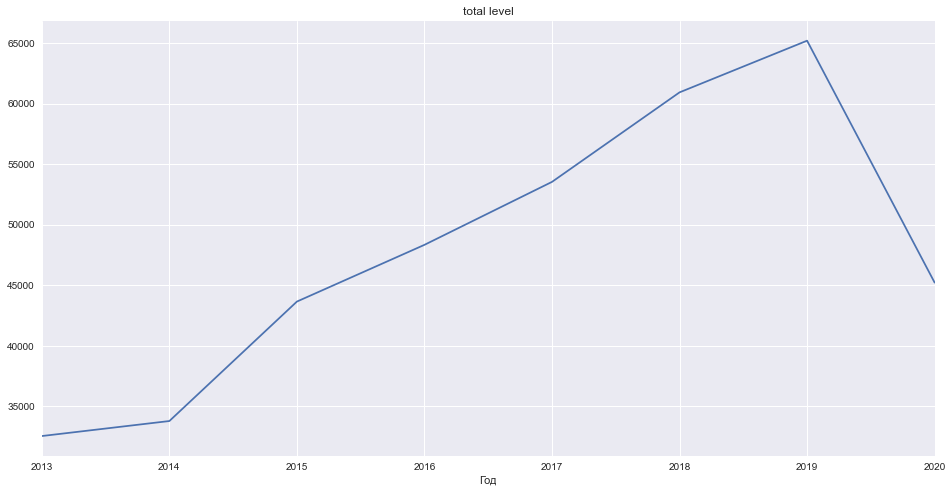

In [17]:
hierarchy_df["total"].plot(title="total level")

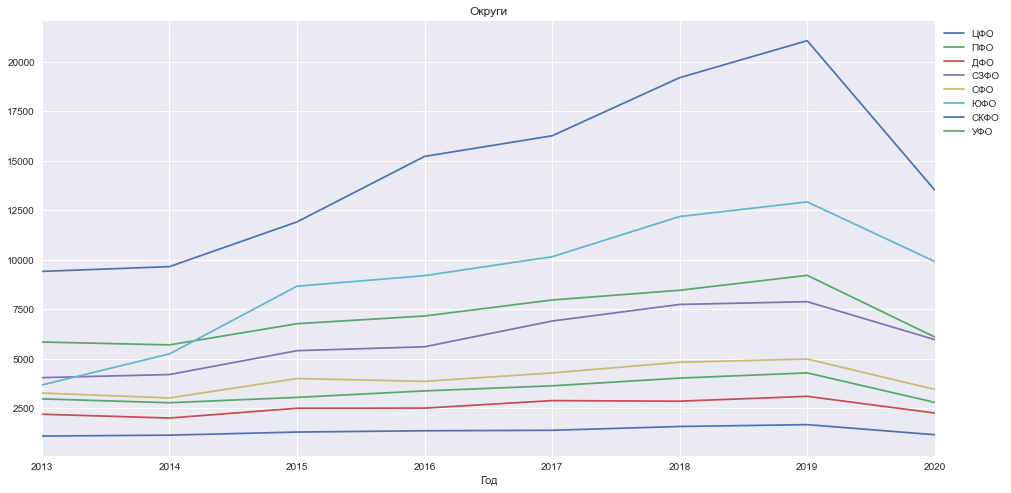

In [18]:
ax = hierarchy_df[hierarchy['total']].plot(title="Округи")
ax.legend(bbox_to_anchor=(1.0, 1.0));

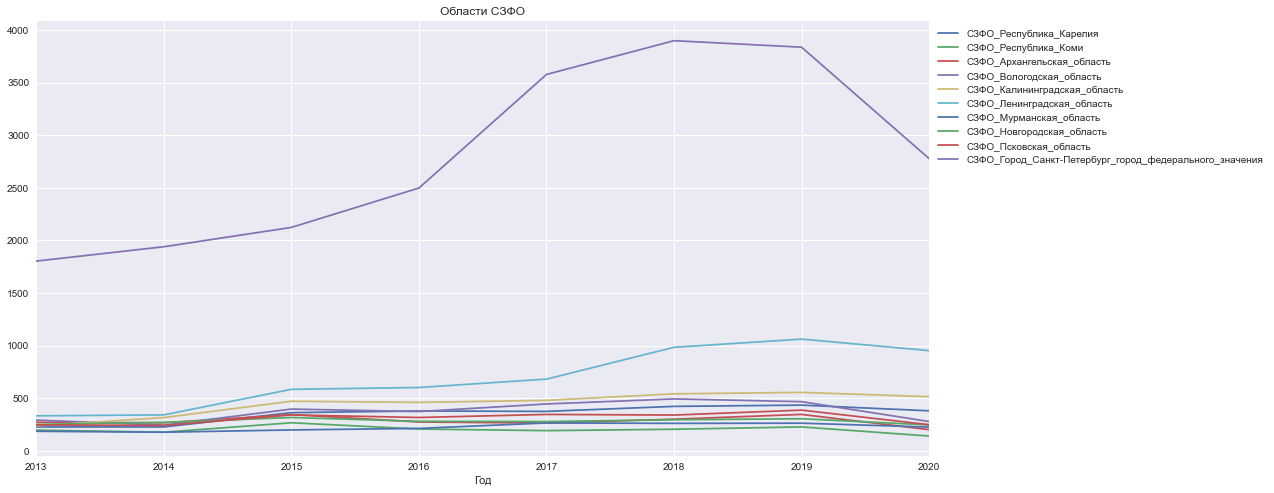

In [19]:
ax = hierarchy_df[hierarchy['СЗФО']].plot(title="Области CЗФО")
ax.legend(bbox_to_anchor=(1.0, 1.0));

In [20]:
steps_ahead = 2

def plot_results(pred_df, source_df, cols_to_plot, mae):
    if type(cols_to_plot) == str:
        cols_to_plot = list(cols_to_plot)
        
    for col in cols_to_plot:
        print('MAE:', round(mae[col], 2))
        fig, ax = plt.subplots()
        pred_df[col].plot(ax=ax, label="Predicted")
        source_df[col].plot(ax=ax, label="Observed")
        
        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Date")
        ax.set_ylabel("Trips")

def get_mae(pred_df, source_df, steps_ahead):
    drop_pred = pred_df.drop(pred_df.tail(steps_ahead).index, inplace=False)
    residuals_abs = abs(drop_pred - source_df)
    return residuals_abs.mean()


In [21]:
# bottom-up approach
model_bu_arima = hts.HTSRegressor(model='auto_arima', revision_method='BU', n_jobs=0)
model_bu_arima = model_bu_arima.fit(hierarchy_df, hierarchy)
pred_bu_arima = model_bu_arima.predict(steps_ahead=steps_ahead)
mae_bu_arima = get_mae(pred_bu_arima, hierarchy_df, steps_ahead)

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 221.95it/s]


MAE: 6889.65


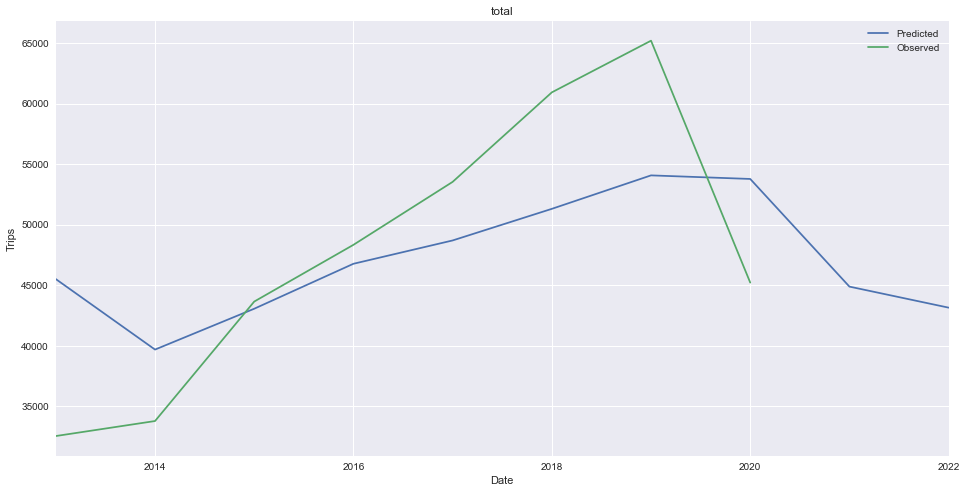

In [22]:
plot_results(pred_bu_arima, hierarchy_df, ['total'], mae_bu_arima)

MAE: 1988.28


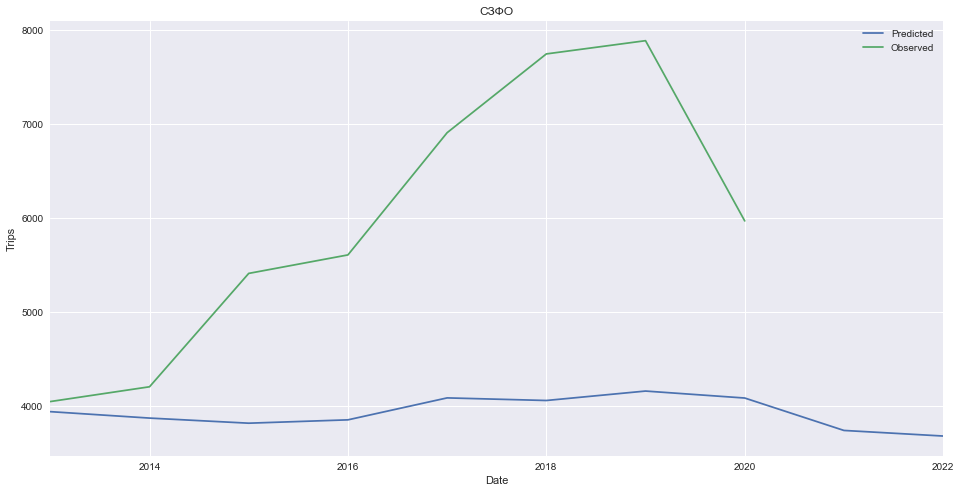

In [23]:
plot_results(pred_bu_arima, hierarchy_df, ['СЗФО'], mae_bu_arima)

MAE: 352.54


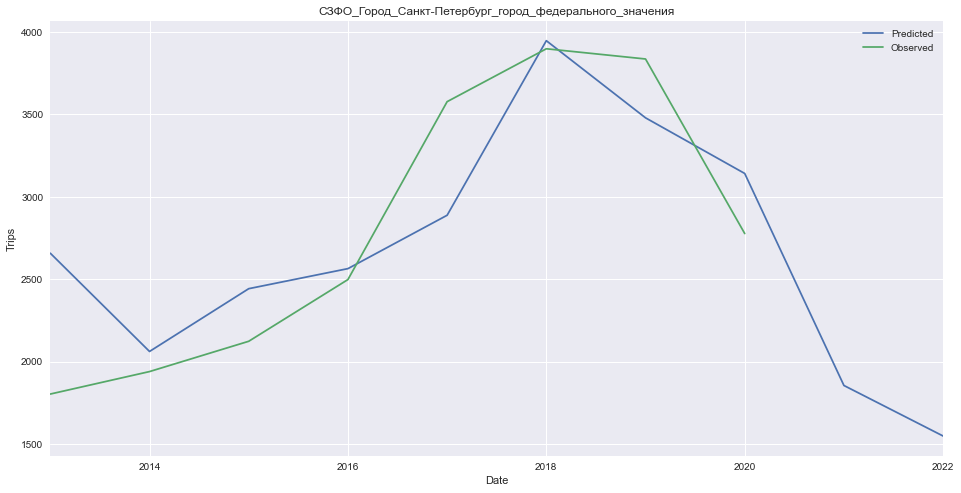

In [24]:
plot_results(pred_bu_arima, hierarchy_df, ['СЗФО_Город_Санкт-Петербург_город_федерального_значения'], mae_bu_arima)

In [25]:
# one of top-down approaches
model_td_arima = hts.HTSRegressor(model='auto_arima', revision_method='AHP', n_jobs=0)
model_td_arima = model_td_arima.fit(hierarchy_df, hierarchy)
pred_td_arima = model_td_arima.predict(steps_ahead=steps_ahead)
mae_td_arima = get_mae(pred_td_arima, hierarchy_df, steps_ahead)

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 178.94it/s]


MAE: 6766.26


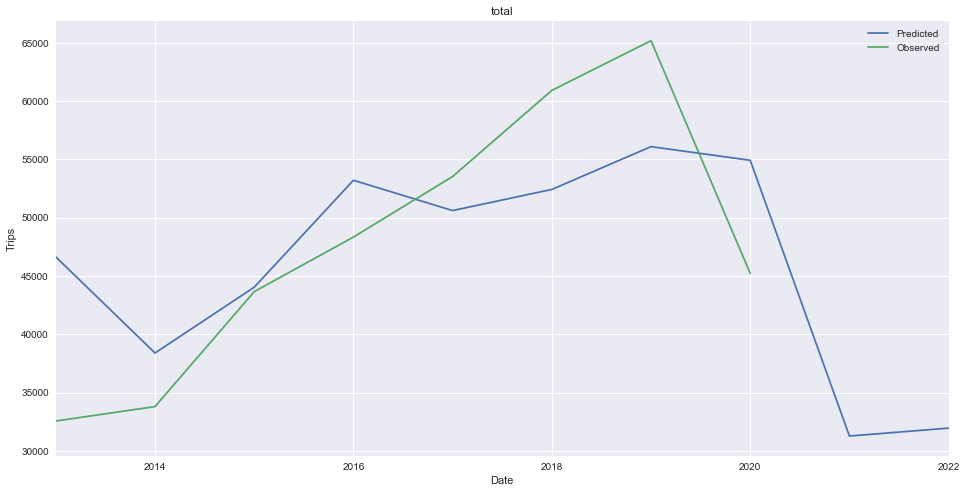

In [26]:
plot_results(pred_td_arima, hierarchy_df, ['total'], mae_td_arima)

MAE: 1800.43


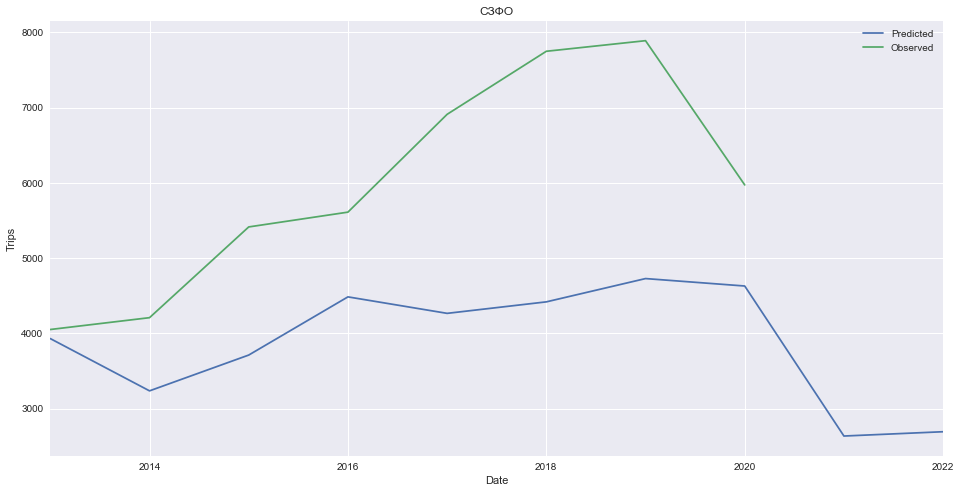

In [27]:
plot_results(pred_td_arima, hierarchy_df, ['СЗФО'], mae_td_arima)

MAE: 587.16


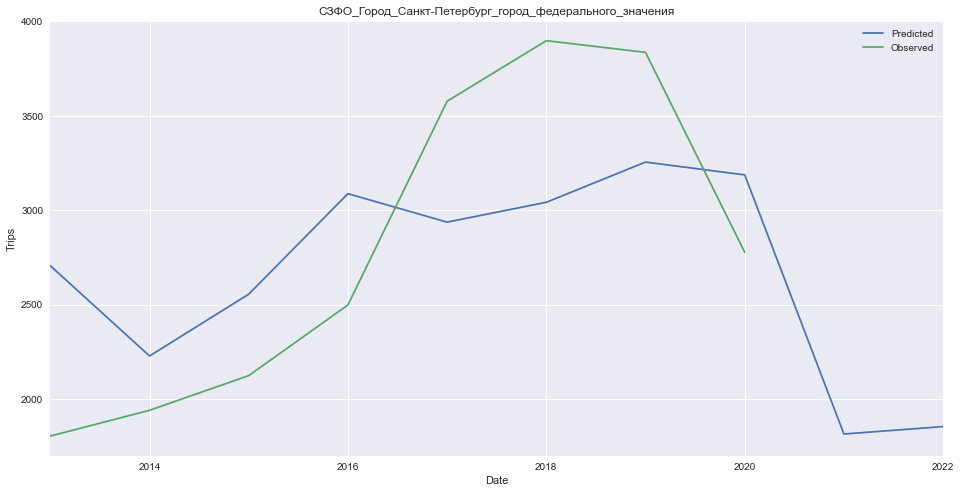

In [28]:
plot_results(pred_td_arima, hierarchy_df, ['СЗФО_Город_Санкт-Петербург_город_федерального_значения'], mae_td_arima)

In [29]:
# optimal reconciliation approach
model_ols_arima = hts.HTSRegressor(model='auto_arima', revision_method='OLS', n_jobs=0)
model_ols_arima = model_ols_arima.fit(hierarchy_df, hierarchy)
pred_ols_arima = model_ols_arima.predict(steps_ahead=2)
mae_ols_arima = get_mae(pred_ols_arima, hierarchy_df, steps_ahead)

Fitting models: 100%|█████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 218.75it/s]


MAE: 6760.03


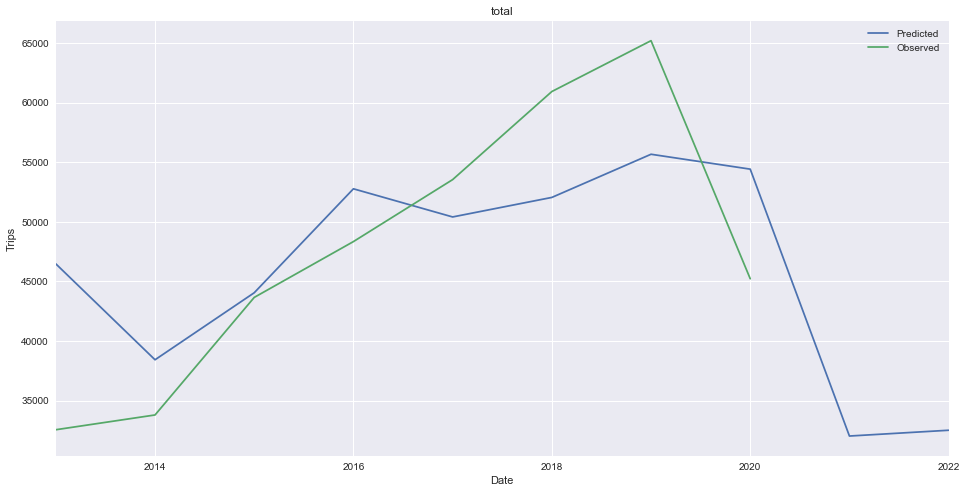

In [30]:
plot_results(pred_ols_arima, hierarchy_df, ['total'], mae_ols_arima)

MAE: 690.77


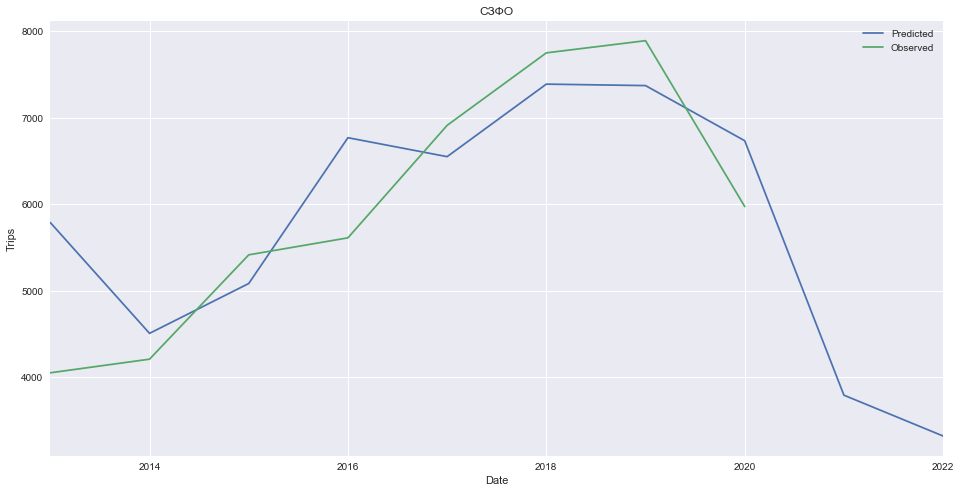

In [31]:
plot_results(pred_ols_arima, hierarchy_df, ['СЗФО'], mae_ols_arima)

MAE: 355.11


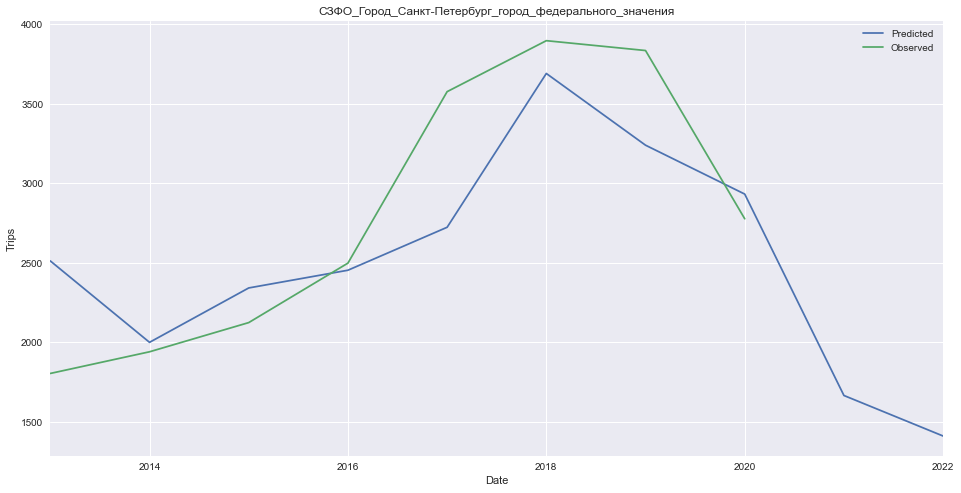

In [32]:
plot_results(pred_ols_arima, hierarchy_df, ['СЗФО_Город_Санкт-Петербург_город_федерального_значения'], mae_ols_arima)